In [ ]:
from google.colab import drive
import os
import numpy as np
import cupy as cp
import pandas as pd
import cudf
from cuml import DBSCAN
from cuml.metrics.cluster.silhouette_score import cython_silhouette_score
from sklearn.metrics import davies_bouldin_score


In [ ]:
import json

def run_dbscan_on_all(pca_data, output_dir, min_samples=5, eps_list=None):
    if eps_list is None:
        eps_list = [0.3, 0.5, 0.7, 1.0, 1.3]

    os.makedirs(output_dir, exist_ok=True)
    results_path = os.path.join(output_dir, "dbscan_results.json")

    # Load existing results to avoid overwriting
    if os.path.exists(results_path):
        with open(results_path, "r") as f:
            results = json.load(f)
    else:
        results = {}

    for name, X in pca_data.items():
        print(f"\n Running DBSCAN on: {name}")
        if name not in results:
            results[name] = {}
        for eps in eps_list:
            print(f"  • eps = {eps}")
            model = DBSCAN(eps=eps, min_samples=min_samples)
            labels = model.fit_predict(X).to_numpy()
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = np.sum(labels == -1)

            metrics = {
                "n_clusters": int(n_clusters),
                "n_noise": int(n_noise),
                "eps": float(eps)
            }

            # Auto-skip silhouette/DBI if dataset is large or cluster structure is invalid
            if 1 < n_clusters < 50 and len(labels) < 300000:
                try:
                    sil = float(cython_silhouette_score(X, labels, metric='euclidean'))
                    dbi = davies_bouldin_score(X.to_numpy(), labels)
                    metrics["silhouette"] = sil
                    metrics["dbi"] = dbi
                except Exception as e:
                    print(f"     Skipped metrics (runtime error): {e}")
                    metrics["silhouette"] = None
                    metrics["dbi"] = None
            else:
                print(f"     Skipped metrics due to size or structure: n={len(labels)}, clusters={n_clusters}")

            # Save cluster labels
            label_filename = f"labels_dbscan_{name}_eps{str(eps).replace('.', '')}.npy"
            np.save(os.path.join(output_dir, label_filename), labels)

            results[name][str(eps)] = metrics

            # Save JSON
            with open(os.path.join(output_dir, "dbscan_results.json"), "w") as f:
                json.dump(results, f, indent=4)

    print("\n All DBSCAN runs complete.")


In [ ]:
from google.colab import drive
import os
import cupy as cp
import cudf

#  Mount your Drive
drive.mount('/content/drive')

#  Paths
input_dir = "/content/drive/MyDrive/NCU/Dissertation/Data/Processed/PCA_Arrays"
output_dir = "/content/drive/MyDrive/NCU/Dissertation/Data/Processed/Clustering/DBSCAN"
os.makedirs(output_dir, exist_ok=True)

#  Load only the 2C and 3C PCA projections (95% skipped)
#X_all_pca_2 = cp.load(os.path.join(input_dir, "X_all_pca_2.npy"))
#X_all_pca_3 = cp.load(os.path.join(input_dir, "X_all_pca_3.npy"))
#X_key_pca_2 = cp.load(os.path.join(input_dir, "X_key_pca_2.npy"))
X_key_pca_3 = cp.load(os.path.join(input_dir, "X_key_pca_3.npy"))

print(" Selected PCA arrays loaded for DBSCAN.")

# Convert CuPy arrays to cuDF DataFrames
def to_cudf(cp_array):
    return cudf.DataFrame(cp_array)

#  Dictionary for DBSCAN
#dbscan_inputs = {
#    "Full (2C)": to_cudf(X_all_pca_2),
#    "Full (3C)": to_cudf(X_all_pca_3),
#    "Key (2C)": to_cudf(X_key_pca_2),
#    "Key (3C)": to_cudf(X_key_pca_3),
#}

#full_configs = {
#    "Full (2C)": to_cudf(X_all_pca_2),
#    "Full (3C)": to_cudf(X_all_pca_3)
#}

#run_dbscan_on_all(full_configs, output_dir, min_samples=5)

key_configs = {
 #   "Key (2C)": to_cudf(X_key_pca_2)
    "Key (3C)": to_cudf(X_key_pca_3)
}
run_dbscan_on_all(key_configs, output_dir, min_samples=5)



# Run DBSCAN clustering on all configs
#run_dbscan_on_all(dbscan_inputs, output_dir, min_samples=5)





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Selected PCA arrays loaded for DBSCAN.

 Running DBSCAN on: Key (3C)
  • eps = 0.3
[2025-05-14 23:54:36.607] [CUML] [warning] Batch size limited by the chosen integer type (4 bytes). 7010 -> 2217. Using the larger integer type might result in better performance
     Skipped metrics due to size or structure: n=968524, clusters=5491
  • eps = 0.5
[2025-05-14 23:55:03.823] [CUML] [warning] Batch size limited by the chosen integer type (4 bytes). 7010 -> 2217. Using the larger integer type might result in better performance
     Skipped metrics due to size or structure: n=968524, clusters=5074
  • eps = 0.7
[2025-05-14 23:55:35.977] [CUML] [warning] Batch size limited by the chosen integer type (4 bytes). 7010 -> 2217. Using the larger integer type might result in better performance
     Skipped metrics due to size or structure: n=968524, clusters=4933
  • eps =

In [6]:
import os
import json
import numpy as np
import pandas as pd

def load_dbscan_visualization_data(base_dir, include_metrics=True):
    """
    Load PCA projections, DBSCAN labels, and fraud labels for visualization.
    Directory structure assumed:
    - base_dir/
        ├── PCA/
        ├── DBSCAN/
        └── y_labels.pkl
    """
    pca_dir = os.path.join(base_dir, "PCA")
    db_dir = os.path.join(base_dir, "DBSCAN")

    data = {}

    # Load fraud labels
    y_path = os.path.join(base_dir, "y_labels.pkl")
    y = pd.read_pickle(y_path)

    index_all = pd.read_csv(os.path.join(base_dir, "index_all_scaled.csv"), index_col=0).index
    index_key = pd.read_csv(os.path.join(base_dir, "index_key_scaled.csv"), index_col=0).index

    data["y_all"] = y.loc[index_all].values
    data["y_key"] = y.loc[index_key].values

    data["index_all"] = index_all
    data["index_key"] = index_key

    # Load PCA arrays
    for fname in os.listdir(pca_dir):
        if fname.endswith(".npy"):
            key = fname.replace(".npy", "")
            data[key] = np.load(os.path.join(pca_dir, fname))

    # Load DBSCAN labels
    for fname in os.listdir(db_dir):
        if fname.startswith("labels_dbscan") and fname.endswith(".npy"):
            key = fname.replace(".npy", "")
            data[key] = np.load(os.path.join(db_dir, fname))

    # Load DBSCAN metrics
    if include_metrics:
        metrics_path = os.path.join(db_dir, "dbscan_results.json")
        if os.path.exists(metrics_path):
            with open(metrics_path, "r") as f:
                data["dbscan_results"] = json.load(f)

    return data


In [7]:
import matplotlib.pyplot as plt

def plot_dbscan_comparison(x, y_true, label_dict, label_display, eps_mapping, dbscan_results, save_path=None):
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8, 16), constrained_layout=True)
    axs = axs.flatten()

    for i, (eps_str, labels) in enumerate(label_dict.items()):
        epsilon_val = eps_mapping[eps_str]
        metrics = dbscan_results.get(label_display, {}).get(str(epsilon_val), {})
        k_val = metrics.get("n_clusters", "?")

        axs[i].scatter(x[:, 0], x[:, 1], c=labels, cmap="cividis", alpha=0.6, s=10, zorder=1)
        axs[i].scatter(x[y_true == 1][:, 0], x[y_true == 1][:, 1], c="red", marker="x", s=10, label="Fraud", zorder=3)
        axs[i].scatter(x[labels == -1][:, 0], x[labels == -1][:, 1], c="gray",alpha=0.3, marker="v", s=6, label="Noise", zorder=2)
        axs[i].set_title(f"ε = {epsilon_val:.2f}, k = {k_val}")
        axs[i].set_xlabel("PC1")
        axs[i].set_ylabel("PC2")

    # 6th panel (bottom right) for legend only
    axs[-1].axis("off")
    handles, labels = axs[0].get_legend_handles_labels()
    axs[-1].legend(handles, labels, loc="center", fontsize="medium")

    fig.suptitle(f"DBSCAN Results for {label_display}", fontsize=16)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


In [8]:
# Config map: (PCA key, fraud label key, list of eps values to visualize)
dbscan_config_map = {
    "Full (2C)": ("x_all_pca_2", "y_all", [0.3, 0.5, 0.7, 1.0, 1.3]),
    "Full (3C)": ("x_all_pca_3", "y_all", [0.3, 0.5, 0.7, 1.0, 1.3]),
    "Key (2C)": ("x_key_pca_2", "y_key", [0.3, 0.5, 0.7, 1.0, 1.3]),
    "Key (3C)": ("x_key_pca_3", "y_key", [0.3, 0.5, 0.7, 1.0, 1.3])
}


 Generating: Full (2C) with ε = [0.3, 0.5, 0.7, 1.0, 1.3]


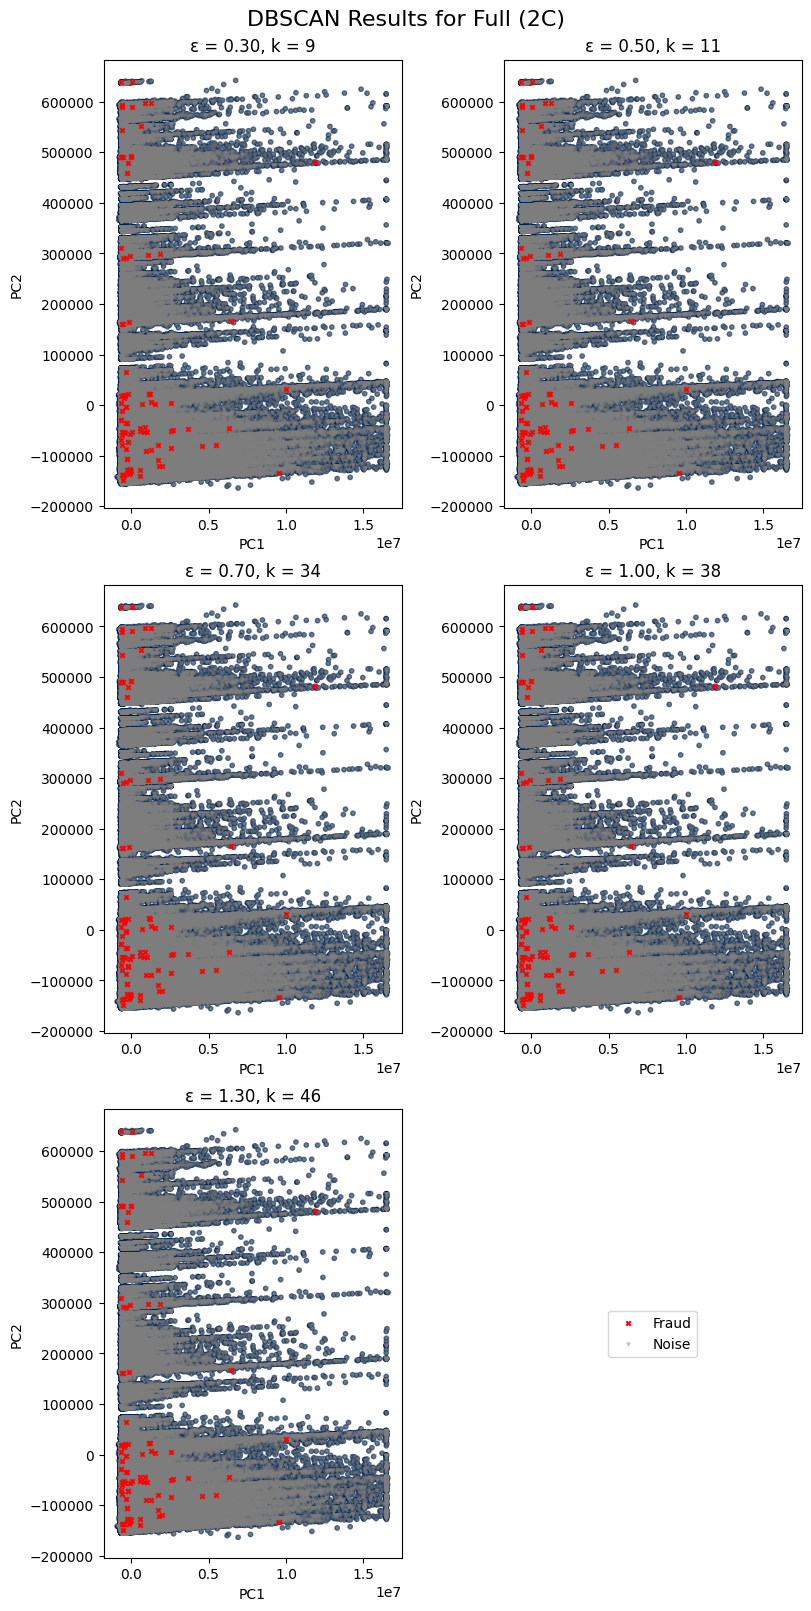

 Generating: Full (3C) with ε = [0.3, 0.5, 0.7, 1.0, 1.3]


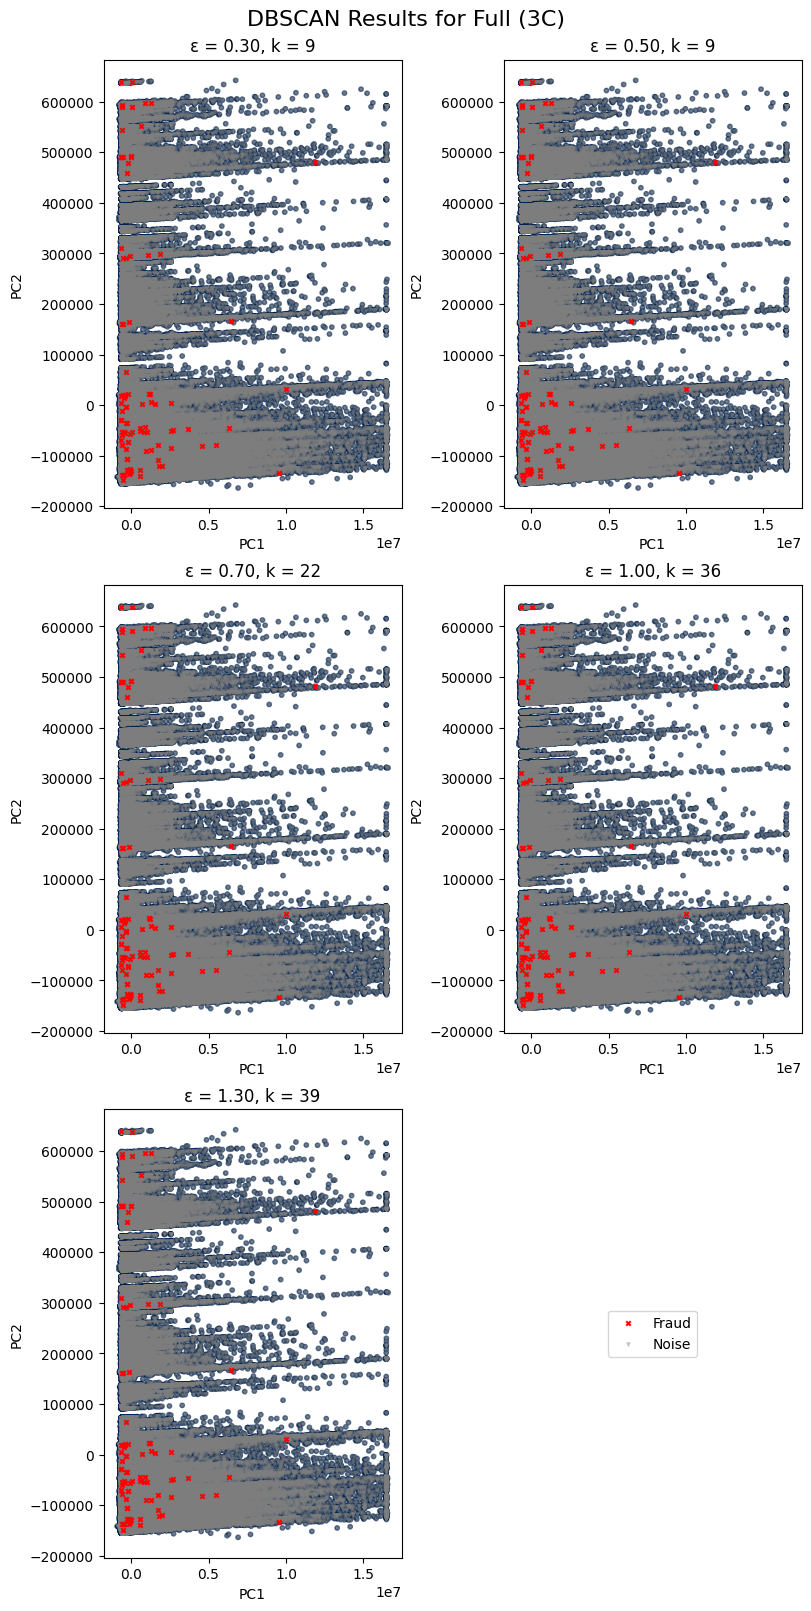

 Generating: Key (2C) with ε = [0.3, 0.5, 0.7, 1.0, 1.3]


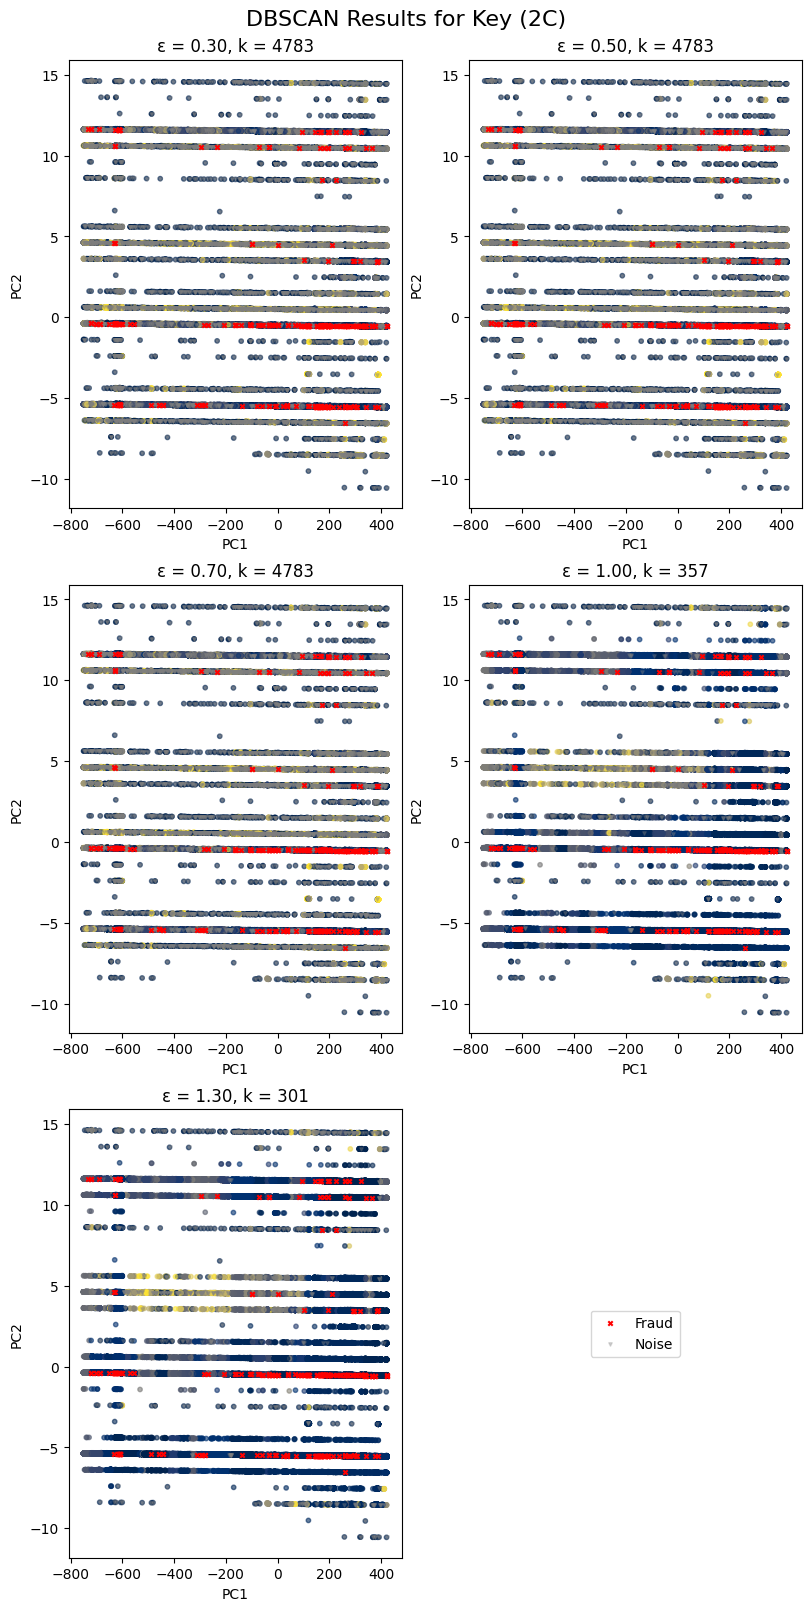

 Generating: Key (3C) with ε = [0.3, 0.5, 0.7, 1.0, 1.3]


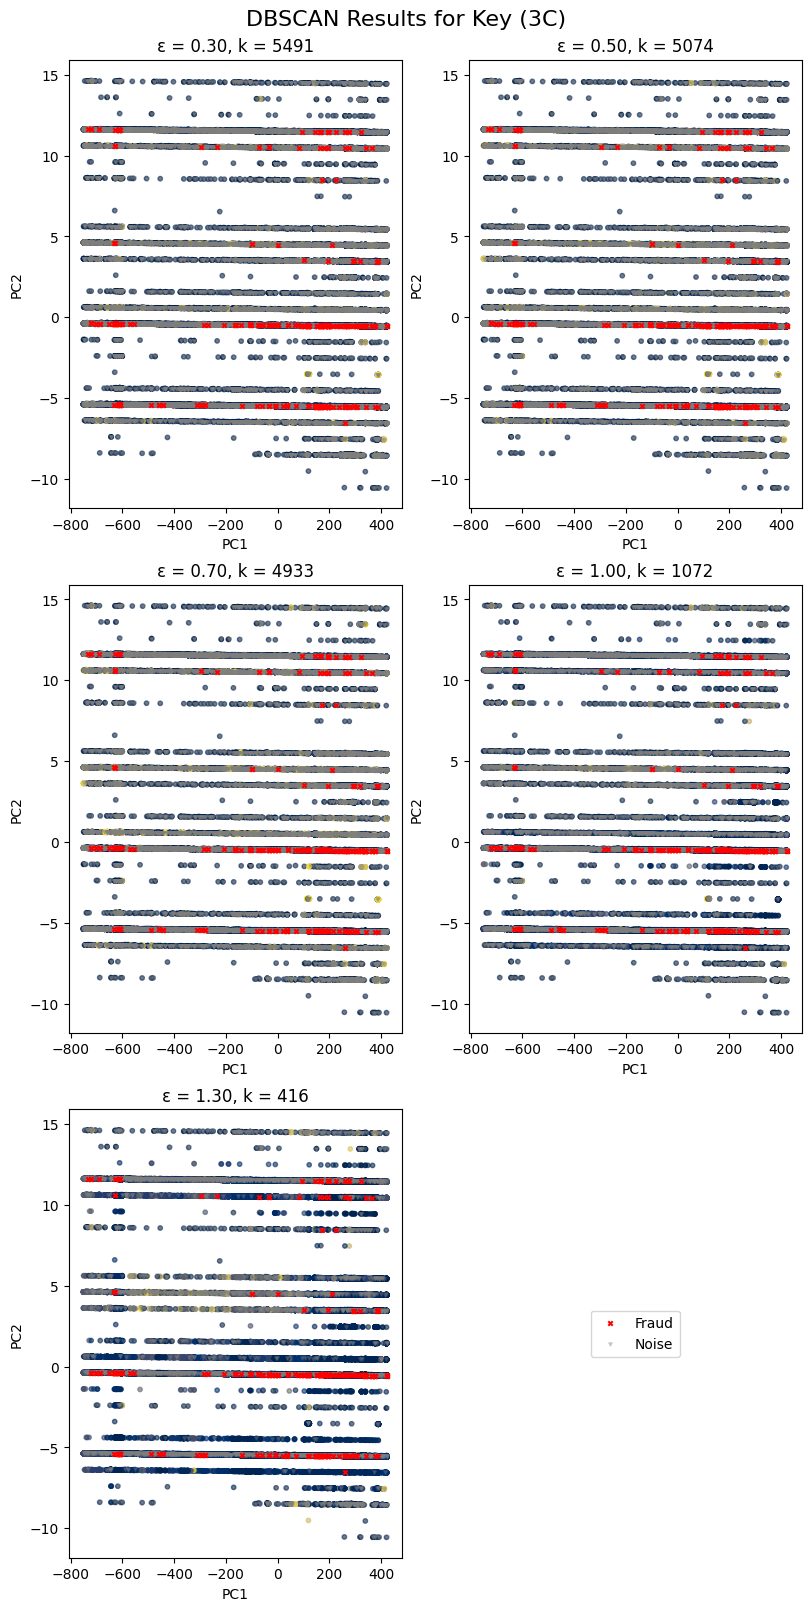

In [9]:
# Set base path and output dir
base_dir = "/content/drive/MyDrive/NCU/Dissertation/Data/Processed/Clustering"
output_dir = "/content/drive/MyDrive/NCU/Dissertation/Figures/DBSCANPlots"
os.makedirs(output_dir, exist_ok=True)

# Load all data
data = load_dbscan_visualization_data(base_dir)

# Generate plots
for label, (x_key, y_key, eps_list) in dbscan_config_map.items():
    x = data[x_key]
    y = data[y_key]

    eps_mapping = {f"{int(eps * 10):02d}": eps for eps in eps_list}
    label_dict = {}

    for eps in eps_list:
        eps_str = f"{int(eps * 10):02d}"
        file_key = f"labels_dbscan_{label}_eps{eps_str}"
        if file_key in data:
            label_dict[eps_str] = data[file_key]
        else:
            print(f"  Missing: {file_key}")

    if label_dict:
        save_path = os.path.join(
            output_dir,
            f"dbscan_comparison_{label.lower().replace(' ', '_').replace('(', '').replace(')', '')}.png"
        )
        print(f" Generating: {label} with ε = {list(eps_mapping.values())}")
        plot_dbscan_comparison(
            x=x,
            y_true=y,
            label_dict=label_dict,
            label_display=label,
            eps_mapping=eps_mapping,
            dbscan_results=data["dbscan_results"],
            save_path=save_path
        )


Figure: DBSCAN Clustering Results – Full Feature Set (2C)
DBSCAN clustering results using the full feature set reduced to two principal components (2C). Each subplot displays clustering outcomes for a different ε value (0.30 to 1.30), with the number of detected clusters (k) annotated in the title. Noise points are shown as gray downward triangles (▾), while known fraudulent observations are marked with red crosses (×). As ε increases, more clusters emerge and noise diminishes, though distinct separation of fraudulent cases remains limited.

Figure: DBSCAN Clustering Results – Full Feature Set (3C)
DBSCAN clustering results on the full feature set reduced to three principal components (3C), projected into two dimensions. Across varying ε values, the model reveals a trend of increasing cluster formation and decreasing noise. However, fraud instances (red ×) remain dispersed and rarely form isolated clusters, suggesting limited discriminative value from the full feature set alone.

Figure: DBSCAN Clustering Results – Key Feature Set (2C)
DBSCAN clustering on the key feature subset with two principal components (2C). Results show markedly improved fraud separability, particularly at ε = 1.00 and ε = 1.30, where noise reduction is accompanied by the emergence of smaller, tighter clusters. Fraudulent observations (red ×) appear more spatially concentrated, indicating enhanced anomaly structure within the key feature space.

Figure: DBSCAN Clustering Results – Key Feature Set (3C)
DBSCAN results using the key feature subset reduced to three components. As ε increases, noise points decline and the number of distinct clusters (k) rises, peaking in spatial structure at ε = 1.30. Compared to the full feature set, the key features yield better fraud localization, especially at intermediate ε levels, highlighting their relevance for semi-supervised anomaly detection.

In [4]:
import numpy as np
import json
from cuml.metrics.cluster.silhouette_score import cython_silhouette_score
from sklearn.metrics import davies_bouldin_score  # fallback if needed

# Load from your saved state
labels_path = "/content/drive/MyDrive/NCU/Dissertation/Data/Processed/Clustering/DBSCAN/labels_dbscan_Key (3C)_eps13.npy"
labels = np.load(labels_path)

# Load corresponding PCA data
x_key_3c = np.load("/content/drive/MyDrive/NCU/Dissertation/Data/Processed/Clustering/PCA/x_key_pca_3.npy")


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
labels = labels.astype(int)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = np.sum(labels == -1)

metrics = {
    "n_clusters": int(n_clusters),
    "n_noise": int(n_noise),
    "eps": 1.3
}

# Only compute silhouette/DBI if more than one cluster
if n_clusters > 1 and n_noise < len(labels):
    try:
        import cuml
        import cupy as cp
        import cudf

        x_gpu = cudf.DataFrame(cp.asarray(x_key_3c))
        sil = float(cython_silhouette_score(x_gpu, labels, metric='euclidean'))
        dbi = davies_bouldin_score(x_key_3c, labels)
        metrics["silhouette"] = sil
        metrics["dbi"] = dbi
    except Exception as e:
        print(f"(Skipping metric calc due to error: {e})")


In [6]:
# Path to existing JSON
json_path = "/content/drive/MyDrive/NCU/Dissertation/Data/Processed/Clustering/DBSCAN/dbscan_results.json"

# Load and update
with open(json_path, "r") as f:
    dbscan_results = json.load(f)

if "Key (3C)" not in dbscan_results:
    dbscan_results["Key (3C)"] = {}

dbscan_results["Key (3C)"]["1.3"] = metrics

# Save it back
with open(json_path, "w") as f:
    json.dump(dbscan_results, f, indent=4)

print(" Injected missing Key (3C), eps=1.3 metrics into JSON.")


 Injected missing Key (3C), eps=1.3 metrics into JSON.


In [10]:
import os
import json
import pandas as pd

# Load your DBSCAN metrics
json_path = "/content/drive/MyDrive/NCU/Dissertation/Data/Processed/Clustering/DBSCAN/dbscan_results.json"
with open(json_path, "r") as f:
    dbscan_results = json.load(f)

# Convert to DataFrame
records = []
for config, eps_data in dbscan_results.items():
    for eps, metrics in eps_data.items():
        eps_val = float(eps)
        k = metrics.get("n_clusters", None)
        noise = metrics.get("n_noise", None)

        sil = metrics.get("silhouette") if "silhouette" in metrics and isinstance(metrics.get("silhouette"), (float, int)) else None
        dbi = metrics.get("dbi") if "dbi" in metrics and isinstance(metrics.get("dbi"), (float, int)) else None

        records.append({
            "Config": config,
            "Epsilon": eps_val,
            "Clusters": k,
            "Noise": noise,
            "Silhouette": sil,
            "DBI": dbi
        })

df = pd.DataFrame(records)

# Filter out runs with excessive clusters
df_filtered = df[df["Clusters"] <= 300]


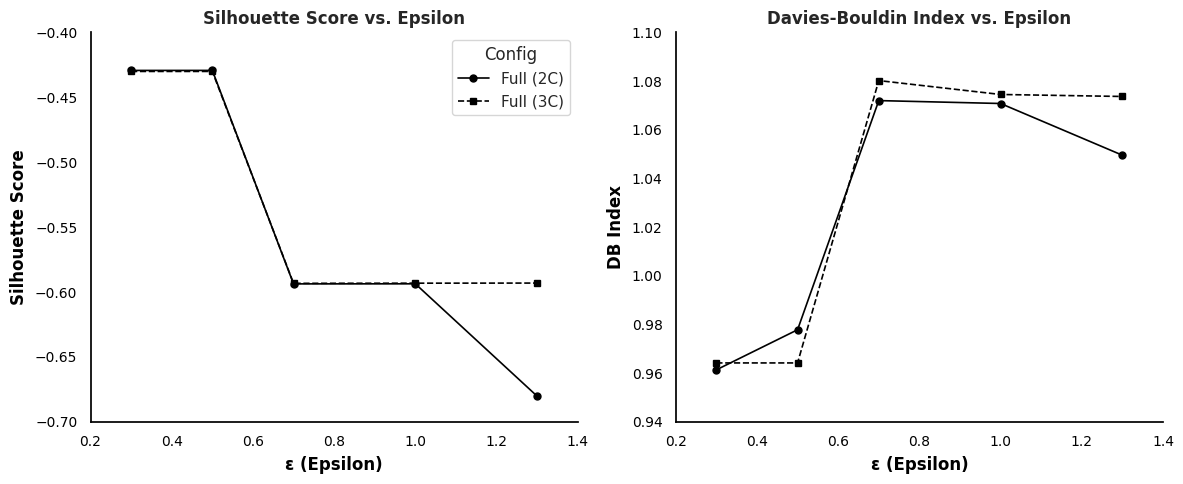

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load APA style
plt.style.use("/content/drive/MyDrive/NCU/Dissertation/apa.mplstyle")

# Define styles manually for clarity
linestyles = {
    "Full (2C)": "solid",
    "Full (3C)": "dashed",
    "Key (2C)": "dashdot",
    "Key (3C)": "dotted"
}
markers = {
    "Full (2C)": "o",
    "Full (3C)": "s",
    "Key (2C)": "x",
    "Key (3C)": "d"
}

configs = df_filtered["Config"].unique()

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# --- Plot: Silhouette Score ---
for config in configs:
    sub_df = df_filtered[df_filtered["Config"] == config]
    axs[0].plot(
        sub_df["Epsilon"],
        sub_df["Silhouette"],
        label=config,
        linestyle=linestyles.get(config, "solid"),
        marker=markers.get(config, "o"),
        color="black",
        markersize=5,
        linewidth=1.2
    )

axs[0].set_title("Silhouette Score vs. Epsilon")
axs[0].set_ylabel("Silhouette Score")
axs[0].set_xlabel("ε (Epsilon)")
axs[0].legend(title="Config")

# --- Plot: DB Index ---
for config in configs:
    sub_df = df_filtered[df_filtered["Config"] == config]
    axs[1].plot(
        sub_df["Epsilon"],
        sub_df["DBI"],
        label=config,
        linestyle=linestyles.get(config, "solid"),
        marker=markers.get(config, "o"),
        color="black",
        markersize=5,
        linewidth=1.2
    )

axs[1].set_title("Davies-Bouldin Index vs. Epsilon")
axs[1].set_ylabel("DB Index")
axs[1].set_xlabel("ε (Epsilon)")
axs[1].legend().remove()

plt.tight_layout()
plt.show()


Figure X. Silhouette Score and Davies–Bouldin Index plotted across ε values for DBSCAN clustering using PCA projections from the Full feature set. Scores are shown for 2-component and 3-component projections. Higher Silhouette values and lower Davies–Bouldin scores indicate more well-defined clustering.

In [16]:
import os
import json
import pandas as pd

# Path to your saved JSON metrics
metrics_path = "/content/drive/MyDrive/NCU/Dissertation/Data/Processed/Clustering/DBSCAN/dbscan_results.json"

# Load results
with open(metrics_path, "r") as f:
    dbscan_results = json.load(f)

# Collect all rows for DataFrame
rows = []

for config, eps_data in dbscan_results.items():
    for eps_str, metrics in eps_data.items():
        eps_val = float(eps_str)

        # Skip configs not starting with "Full" or "Key"
        if not config.startswith(("Full", "Key")):
            continue

        k = metrics.get("n_clusters", "—")
        if k > 300:
            k = "—"
            sil = "—"
            dbi = "—"
        else:
            sil = f'{metrics.get("silhouette", "—"):.3f}' if "silhouette" in metrics else "—"
            dbi = f'{metrics.get("dbi", "—"):.3f}' if "dbi" in metrics else "—"

        rows.append({
            "Configuration": config,
            "ε": eps_val,
            "Clusters (k)": k,
            "Silhouette Score": sil,
            "DB Index": dbi
        })

# Create DataFrame
df = pd.DataFrame(rows)
df = df.sort_values(by=["Configuration", "ε"]).reset_index(drop=True)

# Export to LaTeX
latex_code = df.to_latex(index=False,
                         caption="DBSCAN clustering metrics across configurations and epsilon values. Metrics omitted (—) for configurations exceeding 300 clusters.",
                         label="tab:dbscan_metrics_summary",
                         longtable=True,
                         na_rep="—")

# Save to .tex file
with open("/content/drive/MyDrive/NCU/Dissertation/Figures/DBSCANPlots/dbscan_metrics_table.tex", "w") as f:
    f.write(latex_code)

# Preview
print(latex_code)


\begin{longtable}{lrlll}
\caption{DBSCAN clustering metrics across configurations and epsilon values. Metrics omitted (—) for configurations exceeding 300 clusters.} \label{tab:dbscan_metrics_summary} \\
\toprule
Configuration & ε & Clusters (k) & Silhouette Score & DB Index \\
\midrule
\endfirsthead
\caption[]{DBSCAN clustering metrics across configurations and epsilon values. Metrics omitted (—) for configurations exceeding 300 clusters.} \\
\toprule
Configuration & ε & Clusters (k) & Silhouette Score & DB Index \\
\midrule
\endhead
\midrule
\multicolumn{5}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
Full (2C) & 0.300000 & 9 & -0.429 & 0.961 \\
Full (2C) & 0.500000 & 11 & -0.429 & 0.978 \\
Full (2C) & 0.700000 & 34 & -0.594 & 1.072 \\
Full (2C) & 1.000000 & 38 & -0.594 & 1.071 \\
Full (2C) & 1.300000 & 46 & -0.680 & 1.050 \\
Full (3C) & 0.300000 & 9 & -0.430 & 0.964 \\
Full (3C) & 0.500000 & 9 & -0.430 & 0.964 \\
Full (3C) & 0.700000 & 22 & -0.593 & 1.080

In [17]:
import os
import numpy as np
import pandas as pd

# Base path
base_dir = "/content/drive/MyDrive/NCU/Dissertation/Data/Processed/Clustering"
dbscan_dir = os.path.join(base_dir, "DBSCAN")
output_dir = os.path.join(dbscan_dir, "NoiseIndices")
os.makedirs(output_dir, exist_ok=True)

# Index references (to map cluster labels to original data rows)
index_all = pd.read_csv(os.path.join(base_dir, "index_all_scaled.csv"), index_col=0).index
index_key = pd.read_csv(os.path.join(base_dir, "index_key_scaled.csv"), index_col=0).index

# Config map: name → (projection shape, index)
noise_configs = {
    "Full (2C)": ("x_all_pca_2.npy", index_all),
    "Full (3C)": ("x_all_pca_3.npy", index_all),
    "Key (2C)": ("x_key_pca_2.npy", index_key),
    "Key (3C)": ("x_key_pca_3.npy", index_key),
}

# Eps values you ran
eps_vals = [0.3, 0.5, 0.7, 1.0, 1.3]

# Loop through
for config, (_, idx_ref) in noise_configs.items():
    for eps in eps_vals:
        eps_str = f"{int(eps * 10):02d}"
        label_file = f"labels_dbscan_{config}_eps{eps_str}.npy"
        label_path = os.path.join(dbscan_dir, label_file)

        if not os.path.exists(label_path):
            print(f" Skipped: {label_file} not found.")
            continue

        labels = np.load(label_path)
        if len(labels) != len(idx_ref):
            print(f" Mismatch: {config} ε={eps} — label length {len(labels)} vs index {len(idx_ref)}")
            continue

        noise_mask = (labels == -1)
        noise_ids = idx_ref[noise_mask]

        if len(noise_ids) > 0:
            filename = f"noise_indices_{config.replace(' ', '_').replace('(', '').replace(')', '')}_eps{eps_str}.csv"
            pd.Series(noise_ids).to_csv(os.path.join(output_dir, filename), index=False, header=False)
            print(f" Saved: {filename} ({len(noise_ids)} noise points)")
        else:
            print(f"ℹ No noise points for {config}, ε = {eps}")


 Saved: noise_indices_Full_2C_eps03.csv (940432 noise points)
 Saved: noise_indices_Full_2C_eps05.csv (940420 noise points)
 Saved: noise_indices_Full_2C_eps07.csv (940255 noise points)
 Saved: noise_indices_Full_2C_eps10.csv (940214 noise points)
 Saved: noise_indices_Full_2C_eps13.csv (940063 noise points)
 Saved: noise_indices_Full_3C_eps03.csv (940432 noise points)
 Saved: noise_indices_Full_3C_eps05.csv (940431 noise points)
 Saved: noise_indices_Full_3C_eps07.csv (940340 noise points)
 Saved: noise_indices_Full_3C_eps10.csv (940236 noise points)
 Saved: noise_indices_Full_3C_eps13.csv (940209 noise points)
 Saved: noise_indices_Key_2C_eps03.csv (6592 noise points)
 Saved: noise_indices_Key_2C_eps05.csv (6592 noise points)
 Saved: noise_indices_Key_2C_eps07.csv (6592 noise points)
 Saved: noise_indices_Key_2C_eps10.csv (1108 noise points)
 Saved: noise_indices_Key_2C_eps13.csv (693 noise points)
 Saved: noise_indices_Key_3C_eps03.csv (36154 noise points)
 Saved: noise_indices_Key_